 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

- hist : stateやhandをヒストグラムで表したもの（長さが牌種のリスト）

- kind_tile : 用いる牌の種類数

- num_hand : 手牌の枚数

- NUM_SANE_TILE : 同一牌の枚数(基本的に4で固定)


0=1m, 1=2m, ... , 7=8m, 8=9m, 9=1p, 10=2p, ... ,16=8p, 17=9p, 18=1s, 19=2s, ... ,25=8s, 26=9s, 27=東, ... , 33=中

In [1]:
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import time

random_seed = 0
np.random.seed(random_seed)

### 必要な関数の再定義

In [2]:
def is_valid(seq, NUM_SAME_TILE=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > NUM_SAME_TILE): return False # 牌の上限枚数を超えたらFalse
    return True
    
def generate_all_l(kind_tile, num_hand, NUM_SAME_TILE=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(kind_tile), repeat=num_hand):
        if is_valid(seq, NUM_SAME_TILE):
            gen_list.append(seq)
    return gen_list

def state2hist(state, kind_tile): # 手牌(state)を、牌種ごとの枚数のリスト(長さkind_tile)に変換する関数
    hist = [0] * kind_tile # hist = [0,0,...,0]
    for tile in state:
        hist[tile] += 1
    return hist

def states2hists(state_list, kind_tile): # 手牌(state)のリストを、牌種ごとの枚数のリストに変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        hist = [0] * kind_tile # hist = [0,0,...,0]
        for tile in state:
            hist[tile] += 1
        hist_list.append(hist)
    return hist_list

def state2hist_for_win(state, NUM_KIND_TILES=34): # あがり判定のために牌種の間には0を入れたhistを生成する関数
    hist = [0] * (NUM_KIND_TILES + 9) # hist = [0,0,...,0]
    for tile in state:
        if tile <= 8: # 萬子
            hist[tile] += 1
        elif tile <= 17: # 筒子
            hist[tile + 1] += 1
        elif tile <= 26: # 索子
            hist[tile + 2] += 1
        else: # 字牌
            hist[30 + (tile - 27) * 2] += 1
    return hist

def win_split_sub(hist, two, three, split_state, agari_list):
    if any(x < 0 for x in hist):
        return
    if two == 0 and three == 0:
        agari_list.append(tuple(split_state))
        return
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    next_hist = [x - 2 if i == j else x for j, x in enumerate(hist)]
    if two > 0 and hist[i] == 2: # 雀頭
        win_split_sub(next_hist, two - 1, three, split_state + [(i, i)], agari_list)
    next_hist = [x - 3 if i == j else x for j, x in enumerate(hist)]
    if three > 0 and hist[i] == 3: # 刻子
        win_split_sub(next_hist, two, three - 1, split_state + [(i, i, i)], agari_list)
    next_hist = [x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)]
    if three > 0 and i + 2 < len(hist): # 順子
        win_split_sub(next_hist, two, three - 1, split_state + [(i, i+1, i+2)], agari_list)
    return 
    
def win_split_main(hist): # あがり判定
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    agari_list = []
    win_split_sub(hist, n_two, n_three, [], agari_list)
    if len(agari_list) == 0:
        return (False, set())
    else:
        return (True, agari_list)

def is_tanyao(state):
    for hai in state:
        if hai == 0 or hai == 8:
            return False
    return True

def is_chanta(split_state):
    state_value = True
    for block in split_state:
        if 0 in block or 8 in block:
            continue
        else:
            state_value = False
            break
    return state_value

def is_toitoi(split_state):
    state_value = True
    for block in split_state:
        if len(block) == 2: # 雀頭
            continue
        else:  # 面子
            if block[0] != block[1]:
                state_value = False
                break
    return state_value
    
def is_ipeko(split_state):
    for block in split_state:
        if len(block) == 2:
            continue
        if block[0] != block[1]:
            temp = list(split_state)
            temp.remove(block)
            if block in temp:
                return True
    return False

def hist2onehot(hist, kind_tile, NUM_SAME_TILE=4): # 手牌１つをサイズ(kind_tile, NUM_SAME_TILE)の行列にする
    matrix = np.zeros(shape=(kind_tile, NUM_SAME_TILE))
    for i, num in enumerate(hist):
        if num == 0:
            continue
        else:
            matrix[i][:num] = 1
    return matrix

def hists2onehots(hist_list, kind_tile, NUM_SAME_TILE=4): # 手牌1つ1つをone_hot形式に直す
    onehots = np.zeros((len(hist_list), kind_tile, NUM_SAME_TILE))
    for i in range(len(hist_list)):
        for j, hist_i in enumerate(hist_list[i]):
            if hist_i == 0:
                continue
            else:
                onehots[i][j][:hist_i] = 1
    return onehots

### 教師データの作成

In [5]:
# データの作成時のみ動かす（サイズが小さい時）
kind_tile = 9
num_hand = 5
NUM_SAME_TILE = 4

state_list = generate_all_l(kind_tile, num_hand, NUM_SAME_TILE)
state_hist_list = states2hists(state_list, kind_tile)

is_win_list = []
for state_hist in state_hist_list:
    is_win_list.append(win_split_main(state_hist)[0])
    
np.save('data/state_list_{}_{}'.format(kind_tile, num_hand), np.array(state_list))
np.save('data/is_win_list_{}_{}'.format(kind_tile, num_hand), np.array(is_win_list))

In [28]:
# データの作成時のみ動かす（サイズが大きい時）
NUM_KIND_TILES = 34
kind_tile = 34
num_hand = 14
NUM_SAME_TILE = 4
num_states = 1000000 # 教師データのサイズ
win_rate = 0.3

state_list = []
is_win_list = []
for i in range(num_states):
    if np.random.rand() < win_rate: # あがりの形をtrue_rateの割合で生成
        while(True):
            state = []
            for j in range(4): # 面子を追加
                if np.random.rand() < 0.3: # 刻子
                    tile = np.random.randint(0, kind_tile)
                    for l in range(3):
                        state.append(tile)
                else:
                    while(True):
                        tile = np.random.randint(0, min(kind_tile, 25))
                        if not tile in (7, 8, 16, 17):
                            break
                    for l in range(3):
                        state.append(tile + l)
            tile = np.random.randint(0, kind_tile) # 雀頭
            for m in range(2):
                state.append(tile)
            is_valid = True # 5枚以上同じ牌を使っていないか判定
            for tile in state:
                if state.count(tile) >= 5:
                    is_valid = False
                    break
            if is_valid:
                break
    else:
        all_tile = np.array([i for i in range(kind_tile) for j in range(NUM_SAME_TILE)])
        state = np.random.permutation(all_tile)[:num_hand].tolist()
        
    # 牌譜から生成するのも案
    # 教師データの確率分布が実際の分布と一致するようにするべき（比率の調整は要るだろう）
    # これで実際の牌譜で評価するのは？
    # ミニ麻雀の強化学習の牌譜を使って
    # 13枚の手牌を入力で、各牌があがりかどうかの二値分類で学習（二乗誤差）
    
    state = tuple(sorted(state))
    #print(state)
    hist = state2hist_for_win(state, NUM_KIND_TILES)
    #print(hist)
    state_list.append(state)
    is_win_list.append(win_split_main(hist)[0])
    #print(win_split_main(hist)[0])
    
np.save('data/state_list_{}_{}_{}_{}'.format(kind_tile, num_hand, num_states, win_rate), np.array(state_list))
np.save('data/is_win_list_{}_{}_{}_{}'.format(kind_tile, num_hand, num_states, win_rate), np.array(is_win_list))

In [24]:
for i in range(len(state_list)):
    print(state_list[i], is_win_list[i])

(0, 3, 7, 7, 11, 15, 18, 19, 20, 22, 24, 26, 27, 28) False
(3, 4, 4, 11, 15, 16, 17, 17, 19, 20, 20, 21, 32, 33) False
(4, 5, 8, 9, 10, 11, 11, 17, 18, 23, 29, 29, 31, 31) False
(2, 3, 4, 7, 11, 14, 16, 22, 26, 26, 27, 28, 29, 32) False
(2, 4, 5, 6, 17, 18, 20, 23, 23, 25, 27, 29, 30, 32) False
(1, 1, 12, 16, 17, 20, 22, 22, 24, 28, 28, 29, 30, 30) False
(1, 3, 5, 6, 7, 17, 20, 23, 24, 25, 28, 28, 28, 29) False
(10, 13, 14, 19, 19, 22, 24, 24, 26, 26, 29, 30, 31, 33) False
(2, 4, 7, 7, 8, 9, 16, 17, 17, 19, 20, 26, 31, 33) False
(2, 2, 9, 9, 10, 12, 13, 14, 16, 22, 25, 29, 30, 31) False


0で穴埋めすると実際のサイズより大きくなる

m          9 -> 9

m, p       18 -> 19

m, p, t    25 -> 33

m, p, s    27 -> 29

m, p, s, t 34 -> 43

実際にやるのは萬子のみと全種類くらい？

### 教師あり学習

In [21]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
from sklearn.model_selection import train_test_split

def dense_train(kind_tile, num_hand, epochs, x_path, y_path):
    # 
    NUM_SAME_TILE = 4
    input_shape = (kind_tile, NUM_SAME_TILE)
    
    # モデルの定義
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    # モデルのコンパイル
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    x = np.load(x_path)
    y = np.load(y_path)
    x_hists = states2hists(x, kind_tile)
    x_onehots = hists2onehots(x_hists, kind_tile)
    x_train, x_test, y_train, y_test = train_test_split(x_onehots, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    model.save('models/dense_{}_{}.h5'.format(kind_tile, num_hand))
    return history

def draw_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, acc, 'bo', label='Training acc')
    fig1.plot(epochs, val_acc, 'b', label='Validation acc')

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('accuracy')
    fig.legend(bbox_to_anchor=(0., 0.19, 0.86, 0.102), loc=5)# anchor（凡例）の第２引数がx、第３引数がy

    fig.savefig('draw_pdf/acc_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(acc)))
    plt.show()
    
def draw_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, loss, 'bo', label='Training loss')
    fig1.plot(epochs, val_loss, 'b', label='Validation loss')
    #fig1.title('Training and validation loss')a

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('loss')
    fig.legend(bbox_to_anchor=(0., 0.73, 0.86, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

    fig.savefig('draw_pdf/loss_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(loss)))
    plt.show()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 136)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               35072     
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 6s 90us/sample - loss: 0.1421 - acc: 0.9422 - val_loss: 0.0523 - val_acc: 0.9807
Epoch 2/10
70000/70000 [==============================] - 

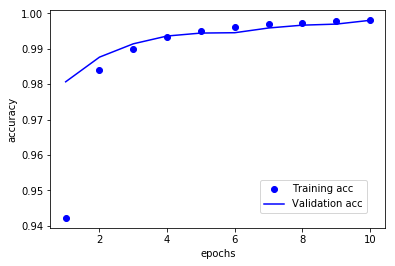

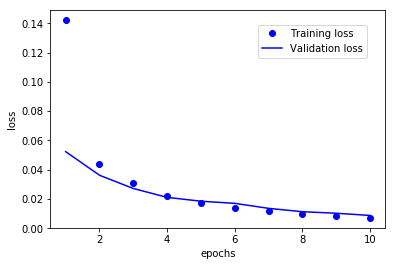

In [22]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
y_path = 'data/is_win_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               9472      
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 5s 75us/sample - loss: 0.4724 - acc: 0.7756 - val_loss: 0.4273 - val_acc: 0.8022
Epoch 2/10
70000/70000 [==============================] - 

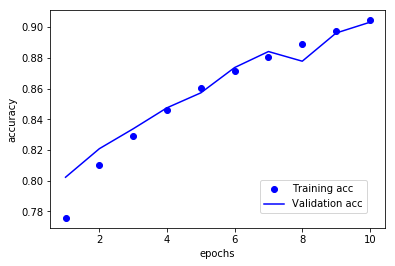

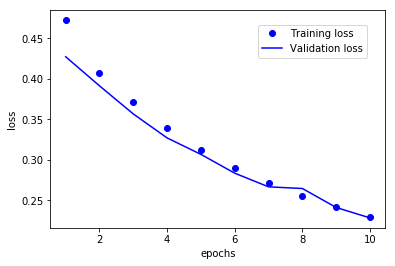

In [23]:
kind_tile = 9
num_hand = 14
x_path = 'data/state_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
y_path = 'data/is_win_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

In [120]:
states = [(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 12), (2,2, 3,3,3,4,4,4,5,5,5), (1, 3, 4, 5, 5, 5, 6, 6, 6, 7, 7), (3, 3, 3, 10, 10, 23, 23, 24, 25, 25, 25)]
hists = states2hists(states, kind_tile)
onehots = hists2onehots(hists, kind_tile)
#print(onehot)
model.predict(onehots)

array([[0.95466336],
       [0.99951955],
       [0.99566901],
       [0.98965103]])

In [124]:
num = 10
ans = model.predict(x_test[:num])
for i in range(num):
    print(x[i], ans[i])
    

[ 1  4  6  7  7  9 10 11 13 13 14 17 18 28] [2.7112908e-19]
[ 6  7  9 10 10 11 18 22 24 30 31 33 33 33] [3.60924067e-12]
[ 1  2  3  6 12 17 18 21 23 24 28 29 30 33] [1.12470861e-32]
[ 6  7  7 12 14 15 15 18 19 20 21 28 31 31] [0.99678415]
[ 0  0  0  6  6  7  7  8  8 25 25 28 28 28] [0.99112002]
[ 3  6 12 14 17 18 19 20 25 27 28 28 30 33] [3.31358031e-39]
[ 5 11 17 18 20 21 22 25 26 26 30 31 32 33] [0.99990096]
[ 0  3  5  9 10 14 14 19 21 28 29 31 31 32] [8.20572096e-13]
[13 13 14 15 16 19 19 20 20 21 21 21 22 23] [2.28736378e-08]
[ 5  6  7  9 10 11 13 13 13 21 21 26 26 26] [0.99994997]


In [67]:
kind_tile = 9
num_hand = 14

# onehotにする方法
x = np.load('data/state_list_9_14_100000_0.3.npy')
for i in range(3):
    a = np.identity(kind_tile)[x[i]]
    print(a)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 

In [68]:
a = np.identity(kind_tile)[x]
a

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0.